<h1>Capstone project</h1>

Ok, the idea of the project is the following:

1. We take a list of all cities with more than 1 million inhabitants in north america (maybe include those in Europe and/or Australia) from Wikipedia https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population (in case these are too many requests, we have to shrink down the number of cities)


2. Things become a bit tricky, we can in principle use the database of geonames at https://download.geonames.org/export/dump/ in order to get all the postal code areas of these places together with coordinates, but the names in wikipedia have to be translated into native languages (and "New York City" in Geonames is "New York").


3. We explore all these areas in Foursquare - the name conversion problem will appear again and I'm not sure yet how it can be fixed easily that the resulting areas do neither overlap - not miss too much of the cities. Well. The search for venues can be used without authentication, so it seems to be unlimited. If we get the shape of the cities, we can generate a hexagonal grid and get all the values. If there are issues with missing coordinates we can replace this by a triangular grid and triangulate all the venues.


4. The idea then is to generate a kind of fingerprint of each city by histograms and other graphs. E.g. the density of restaurants depending on the distance to the center. Of course, another problem arises here which is that some cities might have different number of "centers", but this might be given in the fingerprint. And sure, distances are related to a certain metric which is related to topology, infrastructure, no-go areas and so on. The different centers can be found using k-means and categorized to small, medium, large.


5. Maybe a higher-dimensional version of k-means can be helpful to compare and cluster all the cities


6. What are the differences between the cities? Is there a way to order them according to some dynamics (which shows their future classes with certain probabilities?)


7. Can we learn from those for their future evolution? (Of course, additional information on all levels would be quite helpful to get a better ordering, but this is only a small project ;-) e.g. fingerprints of areas could be correlated to crime rates and types)


8. Which areas need more restaurants, hotels, cafes, what so ever? This information is important for companies to know where to invest or for politicians to get an idea how the cities may develop due to certain decisions,...

<h1 align=center><font size = 5>Compare the largest western cities</font></h1>

## Introduction

...

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

As a first step, dependencies should be resolved.

In [1]:
#import numpy as np # library to handle data in a vectorized manner
#
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#
import json # library to handle JSON files
#
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import geopandas as gpd

#
from bs4 import BeautifulSoup
import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#
## Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
#
## import k-means from clustering stage
#from sklearn.cluster import KMeans
#
##!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
#

from shapely import geometry # create polygonal shapes

print('Libraries imported.')

Libraries imported.


## Download and Explore Dataset

In [2]:
def getNorthAmerica():
    url = "https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    # get relevant table
    table = soup.find(class_="wikitable")
    
    # get all rows
    rows = table.findChildren(['tr'])

    # get the headers
    cols=[]
    headers = rows[0].findChildren('th')
    for header in headers:
        cols.append(header.get_text(strip=True))
    
    cities=[]

    for row in rows:
        city = []
        cells = row.findChildren('td')
        for cell in cells:
            city.append(cell.get_text(strip=True))
            
        cities.append(city)

    df = pd.DataFrame(cities,columns=cols)
        
    return df

In [3]:
dfNA=getNorthAmerica()

In [4]:
dfNA.head()

,,City,Image,Country,Population,Year
0,None,None,None,None,None,None
1,1,Mexico City,,Mexico,"8,918,653[a][3][4]",2015[b]
2,2,New York City,,United States,"8,550,405[5]",2015
3,3,Los Angeles,,United States,"3,971,883[5]",2015
4,4,Toronto,,Canada,"2,826,498[c][7]",2015


In [5]:
# cleaning data
dfNA.dropna(axis=0,inplace=True)
dfNA["Population"]=dfNA["Population"].apply(lambda x: x.split('[')[0])
dfNA["Year"]=dfNA["Year"].apply(lambda x: x.split('[')[0])
dfNA=dfNA.reset_index(drop=True)
dfNA["Population"]=dfNA["Population"].str.replace(",","").astype("int")

In [6]:
dfNA.head()

,,City,Image,Country,Population,Year
0,1,Mexico City,,Mexico,8918653,2015
1,2,New York City,,United States,8550405,2015
2,3,Los Angeles,,United States,3971883,2015
3,4,Toronto,,Canada,2826498,2015
4,5,Chicago,,United States,2720546,2015


In [7]:
# take only relevant information
dfNAmill=dfNA[dfNA["Population"]>1000000][["City","Country","Population"]].reset_index(drop=True)

In [8]:
dfNAmill

,City,Country,Population
0,Mexico City,Mexico,8918653
1,New York City,United States,8550405
2,Los Angeles,United States,3971883
3,Toronto,Canada,2826498
4,Chicago,United States,2720546
5,Houston,United States,2296224
6,Havana,Cuba,2117625
7,Montreal,Canada,1753034
8,Ecatepec de Morelos,Mexico,1677678
9,Philadelphia,United States,1567442


In [9]:
# now fetch the polygons for all the cities
def addPolygons(df,pos):
    df.iloc[pos]
    url = 'https://nominatim.openstreetmap.org/search.php?q={}+{}&polygon_geojson=1&format=json'.format(
      df.loc[pos,"City"],
      df.loc[pos,"Country"]
    )
    return requests.get(url).json()



In [10]:
answer=addPolygons(dfNAmill)

TypeError: addPolygons() missing 1 required positional argument: 'pos'

In [113]:
answer[0]

{'boundingbox': ['33.7036216', '34.337306', '-118.6681776', '-118.1552947'],
 'class': 'place',
 'display_name': 'Los Angeles, Los Angeles County, California, United States of America',
 'geojson': {'coordinates': [[[-118.6681776, 34.185075],
    [-118.6681703, 34.1767732],
    [-118.658589, 34.176749],
    [-118.658609, 34.173095],
    [-118.658609, 34.173025],
    [-118.658618, 34.171517],
    [-118.658618, 34.171419],
    [-118.6586436, 34.1694539],
    [-118.6542859, 34.1694417],
    [-118.6543038, 34.1657418],
    [-118.6455648, 34.1656947],
    [-118.6455843, 34.1619848],
    [-118.6420071, 34.1619856],
    [-118.6397249, 34.1590882],
    [-118.6399365, 34.1591431],
    [-118.6400069, 34.1589942],
    [-118.6399534, 34.1589221],
    [-118.6399698, 34.1588864],
    [-118.6403685, 34.1586733],
    [-118.6412944, 34.1583227],
    [-118.6412981, 34.1567766],
    [-118.6410021, 34.1569017],
    [-118.6408139, 34.1569697],
    [-118.6390745, 34.1575033],
    [-118.6386139, 34.1576492],

In [11]:
dftest.loc[0,"Geometry"]=answer[1]['geojson']['coordinates'][0]

NameError: name 'answer' is not defined

In [12]:
dftest.Geometry=dftest.Geometry.astype("object")

NameError: name 'dftest' is not defined

In [97]:
dftest

,City,Country,Population,Geometry
0,Mexico City,Mexico,8918653,0
1,New York City,United States,8550405,0
2,Los Angeles,United States,3971883,0
3,Toronto,Canada,2826498,0
4,Chicago,United States,2720546,0
5,Houston,United States,2296224,0
6,Havana,Cuba,2117625,0
7,Montreal,Canada,1753034,0
8,Ecatepec de Morelos,Mexico,1677678,0
9,Philadelphia,United States,1567442,0


In [95]:
dftest.dtypes

City          object
Country       object
Population     int64
Geometry      object
dtype: object

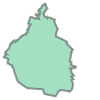

In [79]:
geometry.Polygon(answer[1]['geojson']['coordinates'][0])

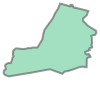

In [110]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

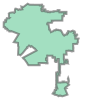

In [115]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0])

In [ ]:


https://nominatim.openstreetmap.org/search.php?q=Warsaw+Poland&polygon_geojson=1&format=json
    https://varunpant.com/posts/how-to-create-fishnets-or-geospatial-grids/

### Europe

In [13]:
def getEurope():
    url = "https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    # get relevant table
    table = soup.find(class_="wikitable")
    
    # get all rows
    rows = table.findChildren(['tr'])

    # get the headers
    cols=[]
    headers = rows[0].findChildren('th')
    for header in headers:
        cols.append(header.get_text(strip=True))
    
    cities=[]

    for row in rows:
        city = []
        cells = row.findChildren('td')
        for cell in cells:
            city.append(cell.get_text(strip=True))
            
        cities.append(city)

    df = pd.DataFrame(cities,columns=cols)
        
    return df

In [14]:
dfE=getEurope()

In [15]:
dfE.head()

,,City,Country,Officialpopulation,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,None,None,None,None,None,None,None,None,None
1,1,Istanbul[a],Turkey,"15,067,724",31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
2,2,Moscow[b],Russia,"12,615,279",1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
3,3,London,United Kingdom,"9,126,366",31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
4,4,Saint Petersburg,Russia,"5,383,890",1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]


In [16]:
def cleanEurope(df):
    # cleaning data
    df.dropna(axis=0,inplace=True)
    df=df.reset_index(drop=True)
    df.rename(columns={"Officialpopulation": "Population"},inplace=True)
    df["Population"]=df["Population"].str.replace(",","").astype("int")
    df["City"]=df["City"].str.split("[").str[0]
    return df

In [17]:
dfE=cleanEurope(dfE)

In [18]:
# take only relevant information
dfEmill=dfE[dfE["Population"]>1000000][["City","Country","Population"]].reset_index(drop=True)

In [19]:
dfEmill

,City,Country,Population
0,Istanbul,Turkey,15067724
1,Moscow,Russia,12615279
2,London,United Kingdom,9126366
3,Saint Petersburg,Russia,5383890
4,Berlin,Germany,3748148
5,Kyiv,Ukraine,3703100
6,Madrid,Spain,3223334
7,Rome,Italy,2857321
8,Paris,France,2140526
9,Bucharest,Romania,2106144


In [41]:
answer=addPolygons(dfEmill,0)

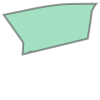

In [37]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

In [22]:
answer=addPolygons(dfEmill,1)

In [46]:
answer[1]

{'boundingbox': ['40.7289169', '41.671', '27.9713956', '29.958148'],
 'class': 'boundary',
 'display_name': 'İstanbul, Marmara Bölgesi, Türkiye',
 'geojson': {'coordinates': [[[27.9713956, 41.1004234],
    [27.9736908, 41.0990141],
    [27.9776012, 41.0990141],
    [27.9782541, 41.0978662],
    [27.9778074, 41.0964702],
    [27.9768613, 41.0947501],
    [27.9766986, 41.0938903],
    [27.9771071, 41.0927879],
    [27.976668, 41.0913517],
    [27.9751639, 41.0904859],
    [27.974511, 41.0876647],
    [27.9758092, 41.0863369],
    [27.9782976, 41.0849419],
    [27.9787131, 41.0844577],
    [27.9789505, 41.0835969],
    [27.9785587, 41.0819894],
    [27.9750333, 41.0801194],
    [27.9744827, 41.0780363],
    [27.975338, 41.0752964],
    [27.9812572, 41.0758541],
    [27.9821277, 41.0749683],
    [27.9818544, 41.073819],
    [27.9816714, 41.0730496],
    [27.981076, 41.072249],
    [27.9817898, 41.0716181],
    [27.9836672, 41.0719398],
    [27.9839906, 41.0718535],
    [27.9839896, 41.0716

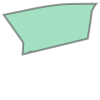

In [27]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

In [47]:
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[geometry.Polygon(answer[1]['geojson']['coordinates'][0])])

testMap = folium.Map(location=[answer[1]["lat"], answer[1]["lon"]], zoom_start=10)

folium.GeoJson(polygon).add_to(testMap)

/home/seyfarth/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [48]:
testMap